In [2]:
%pip install pymorphy2

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import re

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

stopwords_ru = stopwords.words("russian")
# Загрузка данных
dftest = pd.read_csv(
    "https://raw.githubusercontent.com/D4Gj/datasetpromobot/main/train_dataset_train.csv",
    sep=";",
)
dftest["Текст инцидента"] = dftest["Текст инцидента"].str.lower()


def remove_urls(text):
    url_remove = re.compile(r"https?://\S+|www\.\S+")
    return url_remove.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)


def remove_num(text):
    remove = re.sub(r"\d+", "", text)
    return remove


stopwords_ru.extend(
    [
        "на",
        "то",
        "это",
        "так",
        "по",
        "е",
        "зато",
        "есть",
        "ещё",
        "наш",
        "вся",
        "где",
        "г",
        "почему",
        "вы",
        "такие",
        "я",
        "её",
        "сих-пор",
        "ук",
        "это",
        "кто",
        "сейчас",
        "пока",
        "подскажите",
    ]
)


def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]", "", text)
    return punct


# print(stopwords_ru)
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stopwords_ru])


def remove_mention(x):
    text = re.sub(r"@\w+", "", x)
    return text


def remove_hash(x):
    text = re.sub(r"#\w+", "", x)
    return text


def remove_space(text):
    space_remove = re.sub(r"\s+", " ", text).strip()
    return space_remove


dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_urls(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_html(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_num(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: punct_remove(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(
    lambda x: remove_stopwords(x)
)
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_mention(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_hash(x))
dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lambda x: remove_space(x))
dftest.dropna(axis=0)

# Очистка данных
dftest["Текст инцидента"] = dftest["Текст инцидента"].str.lower()
dftest = dftest[dftest["Текст инцидента"].str.len() > 2]
dftest = dftest.dropna(axis=0)

# Лемматизация
import pymorphy2

morph = pymorphy2.MorphAnalyzer()


def lemmatize(doc):
    tokens = []
    for token in doc.split():
        if token and token not in stopwords.words("russian"):
            token = token.strip()
            parsed_token = morph.parse(token)[0]
            normal_form = parsed_token.normal_form
            tokens.append(normal_form)
    if len(tokens) > 2:
        return " ".join(tokens)
    return None


dftest["Текст инцидента"] = dftest["Текст инцидента"].apply(lemmatize)
dftest = dftest.dropna(axis=0)

# Разделение данных на обучающую и тестовую выборки


In [5]:
indexes = dftest[dftest['Тема'] == 'Оказание гос. соц. помощи'].sample(frac=0.5).index
dftest = dftest.drop(indexes)
indexes = dftest[dftest['Тема'] == 'Дети и многодетные семьи'].sample(frac=0.5).index
dftest = dftest.drop(indexes)
indexes = dftest[dftest['Тема'] == '★ Нарушение правил очистки дорог от снега и наледи/Обращения о необходимости очистить тротуар от снега и наледи'].sample(frac=0.5).index
dftest = dftest.drop(indexes)

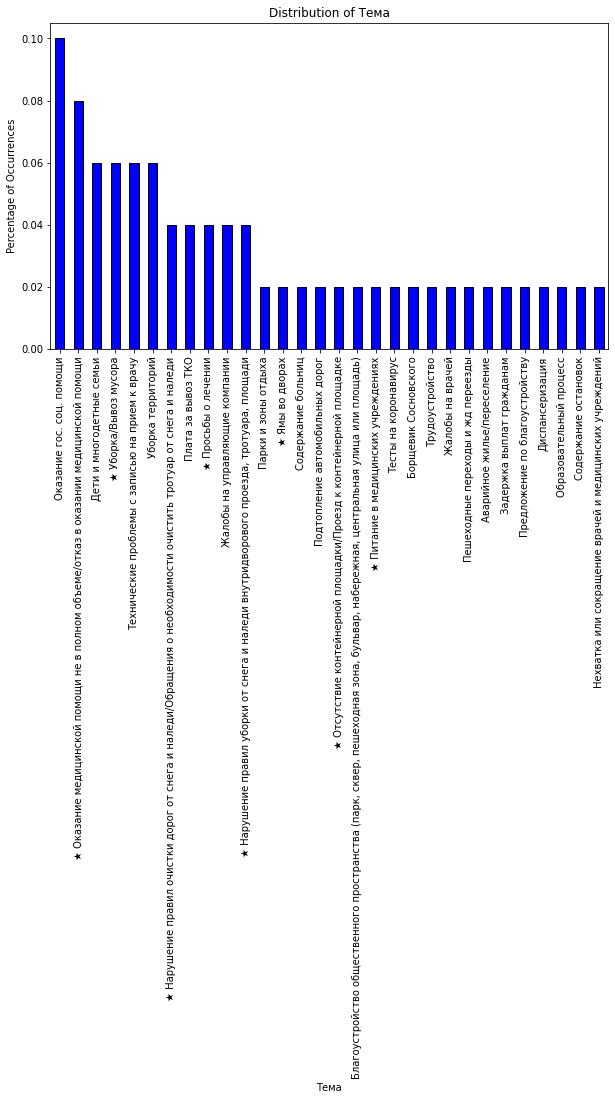

In [6]:
import matplotlib.pyplot as plt

# Calculate the percentage of occurrences for each unique value
label_counts = dftest['Тема'][:50].value_counts(normalize=True)

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Тема')
plt.ylabel('Percentage of Occurrences')
plt.title('Distribution of Тема')

# Show the plot
plt.show()

<ipython-input-7-8e875f9fa40a>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


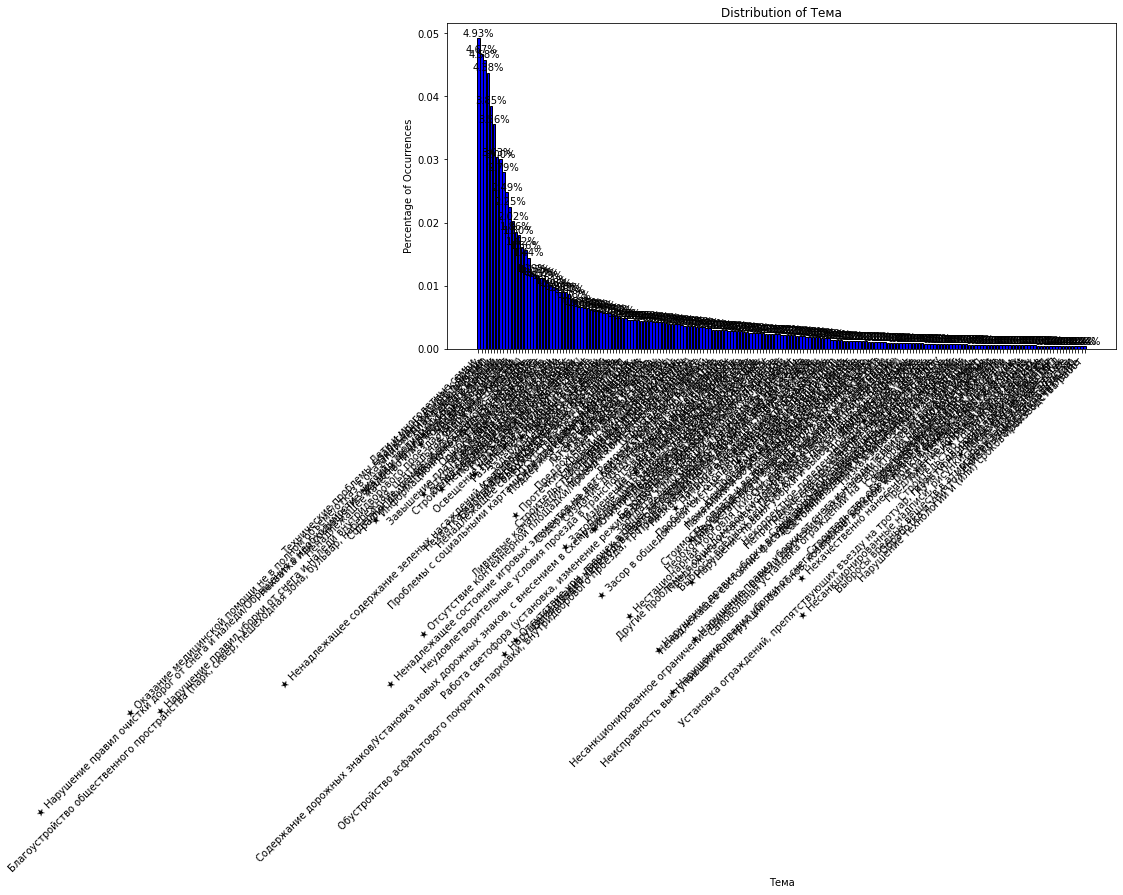

In [7]:
import matplotlib.pyplot as plt

# Calculate the percentage of occurrences for each unique value
label_counts = dftest['Тема'].value_counts(normalize=True)

# Plotting with rotated x-axis labels
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Тема')
plt.ylabel('Percentage of Occurrences')
plt.title('Distribution of Тема')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add data labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
X = dftest["Текст инцидента"]
target = "Тема"
y = dftest[target]

In [9]:
X_train_pd = pd.DataFrame(X.astype(str))

In [10]:
y_train_pd = pd.DataFrame(y.astype(str))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_pd, y_train_pd, test_size=0.10, random_state=42
)

In [17]:
X_train.astype(str)

,Текст инцидента
9772,clubпермский район теплоэнерго очень плохо спр...
8492,здравствуйтеу вопрос ильинский црб посёлок иль...
20466,здравствуйте май гмуж вывести группа инвалидно...
11151,вопрос сосед комната пермь ул черняховский ана...
6058,здравствуйтеписать июль поменялосьво двор губа...
...,...
13259,помочь инвалид гроколо год получать субсидия к...
14072,кировоградский делать быть половина
6291,январь площадь коммуналка выйти тыс
994,добрый утро вопрос сын нигде прописать мама хо...


In [18]:
from catboost import CatBoostClassifier, Pool


def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type="GPU",
        iterations=5000,
        eval_metric="TotalF1",
        od_type="Iter",
        od_wait=500,
        **kwargs
    )

    return model.fit(
        train_pool, eval_set=test_pool, verbose=100, plot=True, use_best_model=True
    )

In [19]:
train_pool = Pool(data=X_train, label=y_train, text_features=["Текст инцидента"])
valid_pool = Pool(data=X_test, label=y_test, text_features=["Текст инцидента"])

In [20]:
model = fit_model(
    train_pool,
    valid_pool,
    learning_rate=0.35,
    dictionaries=[{
        "dictionary_id": "Word",
        "max_dictionary_size": "50000",
        'dictionary_type': 'Bpe',
    }],
    feature_calcers=["BoW:top_tokens_count=10000"],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0964211	test: 0.0958767	best: 0.0958767 (0)	total: 196ms	remaining: 16m 20s
100:	learn: 0.3752317	test: 0.3230992	best: 0.3231564 (99)	total: 18.5s	remaining: 14m 58s
200:	learn: 0.4424049	test: 0.3628680	best: 0.3646405 (196)	total: 35.7s	remaining: 14m 12s
300:	learn: 0.4759378	test: 0.3745151	best: 0.3766563 (279)	total: 52.6s	remaining: 13m 40s
400:	learn: 0.4984020	test: 0.3818466	best: 0.3824946 (395)	total: 1m 9s	remaining: 13m 14s
500:	learn: 0.5186954	test: 0.3833588	best: 0.3862200 (420)	total: 1m 25s	remaining: 12m 50s
600:	learn: 0.5381347	test: 0.3895331	best: 0.3902737 (596)	total: 1m 42s	remaining: 12m 32s
700:	learn: 0.5500784	test: 0.3891550	best: 0.3907457 (686)	total: 1m 59s	remaining: 12m 11s
800:	learn: 0.5676656	test: 0.3942309	best: 0.3948528 (771)	total: 2m 15s	remaining: 11m 51s
900:	learn: 0.5800564	test: 0.3969644	best: 0.3981409 (875)	total: 2m 32s	remaining: 11m 32s
1000:	learn: 0.5919138	test: 0.3893813	best: 0.3981409 (875)	total: 2m 48s	remai

KeyboardInterrupt: 

In [ ]:
from datetime import datetime
print(datetime.now())

In [ ]:
f1 = model.get_best_score()['validation']['TotalF1']

In [ ]:
model.save_model(f'{f1:.3f} {target} {datetime.now()}')